In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




In [2]:

print(" Đang đọc dữ liệu từ file 'original_file.csv'...")

try:
    # Đọc file dữ liệu
    df = pd.read_csv("original_file.csv")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'original_file.csv'. Hãy kiểm tra lại đường dẫn.")
    exit()

 Đang đọc dữ liệu từ file 'original_file.csv'...


In [3]:
# Đổi tên cột để dễ xử lý trong code
column_mapping = {
    'numeric_id': 'subject_id',    # Định danh người bệnh
    'FIX_DURATION': 'duration',    # Thời gian nhìn
    'FIX_X': 'x',                  # Tọa độ X
    'FIX_PUPIL': 'pupil',          # 
    'FIX_Y': 'y',                  # Tọa độ Y
    'label': 'label'               # Nhãn (0 hoặc 1)
}

df = df.rename(columns=column_mapping)

In [4]:
print(f"Tổng số dòng dữ liệu: {len(df)}")
df.head(10)

Tổng số dòng dữ liệu: 225159


,IMAGE,FIX_INDEX,duration,x,y,pupil,source_file,subject_id,label,image_id
0,outman_054.jpg,1,205,518.5,371.3,1177,000.xlsx,0,0,53
1,outman_054.jpg,2,90,275.1,282.2,1262,000.xlsx,0,0,53
2,outman_054.jpg,3,305,600.3,271.1,1265,000.xlsx,0,0,53
3,outman_054.jpg,4,269,635.2,269.2,1326,000.xlsx,0,0,53
4,outman_054.jpg,5,318,597.3,266.0,1366,000.xlsx,0,0,53
5,outman_054.jpg,6,585,575.4,269.3,1442,000.xlsx,0,0,53
6,outman_054.jpg,7,531,610.9,274.1,1508,000.xlsx,0,0,53
7,outman_054.jpg,8,336,595.0,333.7,1577,000.xlsx,0,0,53
8,outman_054.jpg,9,400,597.8,599.6,1687,000.xlsx,0,0,53
9,outman_054.jpg,10,325,550.1,580.0,1756,000.xlsx,0,0,53


In [5]:
def extract_features_per_image(df_raw):
    print("Đang trích xuất đặc trưng theo từng ảnh (Trial-based)...")
    features_list = []
    
    # 1. QUAN TRỌNG: Sắp xếp dữ liệu để đảm bảo thứ tự các điểm nhìn đúng theo thời gian
    # Phải sort theo Người -> Ảnh -> Thứ tự điểm nhìn
    df_raw = df_raw.sort_values(by=['subject_id', 'image_id', 'FIX_INDEX'])
    
    # 2. Gom nhóm theo CẶP (Người, Ảnh) thay vì chỉ Người
    grouped = df_raw.groupby(['subject_id', 'image_id'])
    
    for (sub_id, img_id), group in grouped:
        # Bỏ qua nếu quá ít điểm nhìn trong 1 ảnh (nhiễu)
        if len(group) < 3: continue
            
        label = group['label'].iloc[0]
        
        # --- A. TIME ---
        durs = group['duration']
        dur_mean = durs.mean()
        dur_std = durs.std()
        
        # --- B. MOVEMENT & SCANPATH ---
        # Tính khoảng cách giữa các điểm (Saccade amplitude)
        dx = group['x'].diff().fillna(0)
        dy = group['y'].diff().fillna(0)
        dist = np.sqrt(dx**2 + dy**2)
        
        path_length = dist.sum()   # Tổng quãng đường mắt di chuyển trên bức ảnh này
        sac_mean = dist.mean()
        
        # --- C. PUPIL ---
        pupils = group['pupil']
        pupil_mean = pupils.mean()
        pupil_std = pupils.std()
        
        # --- D. SCANPATH TREND (Xu hướng theo thứ tự nhìn) ---
        # Tạo mảng index [0, 1, 2...]
        indices = np.arange(len(group))
        
        # Xem độ giãn đồng tử thay đổi thế nào từ đầu đến cuối bức ảnh
        # Slope > 0: Càng nhìn càng giãn. Slope < 0: Càng nhìn càng co.
        if len(group) > 1:
            slope_pupil = linregress(indices, pupils).slope
            slope_dist = linregress(indices, dist).slope
        else:
            slope_pupil = 0
            slope_dist = 0

        # --- TỔNG HỢP ---
        features_list.append({
            'subject_id': sub_id,
            'image_id': img_id,      # Giữ lại ID ảnh để truy vết nếu cần
            
            'dur_mean': dur_mean,
            'dur_std': dur_std,
            'path_length': path_length,
            'sac_mean': sac_mean,
            'pupil_mean': pupil_mean,
            'pupil_std': pupil_std,
            'slope_pupil': slope_pupil,
            'slope_dist': slope_dist,
            
            'label': label
        })
        
    return pd.DataFrame(features_list)

# Thực hiện
df_features = extract_features_per_image(df)
print(f" Đã xong! Kích thước dữ liệu mới: {df_features.shape}")
print(df_features.head())

Đang trích xuất đặc trưng theo từng ảnh (Trial-based)...
 Đã xong! Kích thước dữ liệu mới: (15701, 11)
   subject_id  image_id    dur_mean     dur_std  path_length    sac_mean  \
0           0         0  224.947368   87.932723  3868.191184  203.589010   
1           0         1  259.058824  143.955927  3165.197599  186.188094   
2           0         2  243.111111  138.325655  4129.817169  229.434287   
3           0         3  269.187500  102.424749  2835.736416  177.233526   
4           0         4  260.176471   92.023934  2454.217500  144.365735   

    pupil_mean   pupil_std  slope_pupil  slope_dist  label  
0  1361.526316  156.283350    18.336842   10.439449      0  
1  1385.705882  203.932821    32.698529    1.999055      0  
2  1401.888889  150.209614    23.923633   17.091437      0  
3  1532.125000  152.788252    25.952941   20.289371      0  
4  1227.823529  142.302159    14.943627    7.648816      0  


In [6]:
# --- PHẦN 2: CHUẨN BỊ DỮ LIỆU ---
# X: Bỏ các cột định danh (ID) và Nhãn (Label), chỉ giữ lại chỉ số đặc trưng
X = df_features.drop(columns=['subject_id', 'image_id', 'label'])
y = df_features['label']
groups = df_features['subject_id']  # Cột này dùng để chia nhóm train/test

# --- PHẦN 3: CHIA TRAIN/TEST (CHỐNG RÒ RỈ DỮ LIỆU) ---
print(" Đang chia dữ liệu theo GroupShuffleSplit...")
# n_splits=1: Chỉ chia 1 lần
# test_size=0.2: 20% số người sẽ được dùng để test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Lấy ra index của các dòng thuộc tập train và test
train_idx, test_idx = next(gss.split(X, y, groups))

# Tạo tập dữ liệu thực tế từ index
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Lưu lại ID của những người trong tập Test để lát nữa gom nhóm đánh giá
subject_ids_test = groups.iloc[test_idx]

print(f" Dữ liệu Train: {len(X_train)} mẫu (ảnh)")
print(f" Dữ liệu Test:  {len(X_test)} mẫu (ảnh)")

# --- PHẦN 4: HUẤN LUYỆN MÔ HÌNH (RANDOM FOREST) ---
# Random Forest không cần StandardScaler, xử lý tốt nhiễu và dữ liệu mất cân bằng
print("\n Đang huấn luyện mô hình Random Forest...")
model = RandomForestClassifier(
    n_estimators=200,      # Số lượng cây quyết định
    max_depth=10,          # Độ sâu tối đa để tránh học vẹt (overfitting)
    class_weight='balanced', # Tự động cân bằng trọng số nếu dữ liệu lệch
    random_state=42,
    n_jobs=-1              # Dùng tất cả nhân CPU để chạy cho nhanh
)

model.fit(X_train, y_train)
print("Huấn luyện hoàn tất!")

# --- PHẦN 5: ĐÁNH GIÁ THEO CẤP ĐỘ NGƯỜI (SUBJECT LEVEL) ---
def evaluate_subject_level(model, X_test, y_test, subject_ids_test):
    """
    Hàm này gom kết quả dự đoán của tất cả các ảnh thuộc về 1 người
    để đưa ra chẩn đoán cuối cùng cho người đó.
    """
    print("\n" + "="*40)
    print(" KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG (CƠ CHẾ HỘI CHẨN)")
    print("="*40)

    # 1. Lấy xác suất bị bệnh (cột index 1) cho từng bức ảnh
    probs_img = model.predict_proba(X_test)[:, 1]
    
    # 2. Tạo bảng tạm để tính toán
    results_df = pd.DataFrame({
        'subject_id': subject_ids_test.values, # Phải dùng .values để khớp index
        'true_label': y_test.values,
        'prob_sick': probs_img
    })
    
    # 3. Gom nhóm theo người và tính trung bình xác suất
    subject_results = results_df.groupby('subject_id').agg({
        'true_label': 'first',   # Nhãn thực tế của người đó
        'prob_sick': 'mean'      # Trung bình cộng xác suất các ảnh họ đã xem
    }).reset_index()
    
    # 4. Ra quyết định: Nếu trung bình > 0.5 thì kết luận là BỆNH (1), ngược lại là KHỎE (0)
    subject_results['final_pred'] = (subject_results['prob_sick'] > 0.5).astype(int)
    
    # 5. In báo cáo
    final_acc = accuracy_score(subject_results['true_label'], subject_results['final_pred'])
    print(f"Tổng số bệnh nhân trong tập Test: {len(subject_results)} người")
    print(f" ĐỘ CHÍNH XÁC (ACCURACY): {final_acc:.4f} ({final_acc*100:.2f}%)")
    
    print("\nChi tiết báo cáo:")
    print(classification_report(subject_results['true_label'], subject_results['final_pred']))
    
    return subject_results

# Gọi hàm đánh giá
final_results = evaluate_subject_level(model, X_test, y_test, subject_ids_test)

 Đang chia dữ liệu theo GroupShuffleSplit...
 Dữ liệu Train: 12579 mẫu (ảnh)
 Dữ liệu Test:  3122 mẫu (ảnh)

 Đang huấn luyện mô hình Random Forest...
Huấn luyện hoàn tất!

 KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG (CƠ CHẾ HỘI CHẨN)
Tổng số bệnh nhân trong tập Test: 32 người
 ĐỘ CHÍNH XÁC (ACCURACY): 0.7188 (71.88%)

Chi tiết báo cáo:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        16
           1       0.77      0.62      0.69        16

    accuracy                           0.72        32
   macro avg       0.73      0.72      0.72        32
weighted avg       0.73      0.72      0.72        32



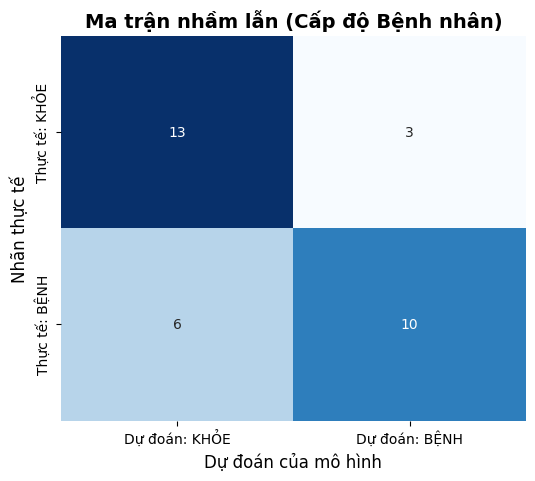

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred):
    # 1. Tính toán ma trận
    cm = confusion_matrix(y_true, y_pred)
    
    # 2. Thiết lập hình vẽ
    plt.figure(figsize=(6, 5))
    
    # 3. Vẽ Heatmap bằng Seaborn
    # annot=True: Hiển thị con số trong ô
    # fmt='d': Định dạng số nguyên (integer) thay vì số khoa học
    # cmap='Blues': Tông màu xanh (đậm là số lượng nhiều)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Dự đoán: KHỎE', 'Dự đoán: BỆNH'],
                yticklabels=['Thực tế: KHỎE', 'Thực tế: BỆNH'])
    
    # 4. Trang trí
    plt.xlabel('Dự đoán của mô hình', fontsize=12)
    plt.ylabel('Nhãn thực tế', fontsize=12)
    plt.title('Ma trận nhầm lẫn (Cấp độ Bệnh nhân)', fontsize=14, fontweight='bold')
    plt.show()

# --- THỰC HIỆN VẼ ---
# Lấy dữ liệu từ bảng kết quả final_results ở bước trước
plot_cm(final_results['true_label'], final_results['final_pred'])